In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import gym
import ray
from ray.tune.logger import pretty_print
import json

In [2]:
ray.init(num_cpus=8, num_gpus=1, ignore_reinit_error=True, log_to_driver=False)

2020-03-14 23:28:49,661	WARNING services.py:586 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-03-14 23:28:49,663	INFO resource_spec.py:212 -- Starting Ray with 6.1 GiB memory available for workers and up to 3.07 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-03-14 23:28:49,982	INFO services.py:1078 -- View the Ray dashboard at localhost:8266


{'node_ip_address': '10.236.176.76',
 'redis_address': '10.236.176.76:14833',
 'object_store_address': '/tmp/ray/session_2020-03-14_23-28-49_661065_11588/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-03-14_23-28-49_661065_11588/sockets/raylet',
 'webui_url': 'localhost:8266',
 'session_dir': '/tmp/ray/session_2020-03-14_23-28-49_661065_11588'}

In [4]:
from ray.rllib.agents.ppo import PPOTrainer, DEFAULT_CONFIG

In [5]:
config = DEFAULT_CONFIG.copy()
# ------- PPO ------
config['num_workers'] = 7
config['num_envs_per_worker'] = 5
config['sample_batch_size'] = 50
config['train_batch_size'] = 1000
config['num_gpus'] = 1
config['lambda'] = 0.95
config['kl_coeff']= 0.5
config["sgd_minibatch_size"] = 500
config["num_sgd_iter"]= 10
config["vf_share_layers"] = True
config['clip_rewards'] = True
config['clip_param']= 0.1
config['vf_clip_param']= 10.0
config['entropy_coeff'] = 0.01
config['model']['dim'] = 42

In [6]:
checkpoint_path = '/home/qian/ray_results/PPO_PongNoFrameskip-v4_2020-03-11_18-30-45ra7xdyge/checkpoint_1158/checkpoint-1158'
trained_config = config.copy()
agent = PPOTrainer(trained_config, 'PongNoFrameskip-v4')
agent.restore(checkpoint_path)

2020-03-14 23:28:55,522	INFO trainer.py:420 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
2020-03-14 23:28:55,538	INFO trainer.py:580 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
/home/qian/anaconda3/envs/ray/lib/python3.7/site-packages/ray/rllib/utils/from_config.py:134: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  obj = yaml.load(type_)
2020-03-14 23:29:01,554	WARNING util.py:37 -- Install gputil for GPU system monitoring.
2020-03-14 23:29:01,666	WARNING trainable.py:210 -- Getting current IP.
2020-03-14 23:29:01,667	INFO trainable.py:416 -- Restored on 10.236.176.76 from checkpoint: /home/qian/ray_results/PPO_PongNoFrameskip-v4_2020-03-11_18-30-45ra7xdyge/checkpoint_1158/checkpoint-1158
2020-03-14 23:29:01,668	INFO trainable.py:423 -- Current state after restor

In [7]:
from gym import wrappers

env = agent.workers.local_worker().env
env = wrappers.Monitor(env, "./gym-results-ppo", force=True)
env.reset()

obs = env.observation_space.sample()
print(obs.shape)
accum = 0
for _ in range(10000):
    frames = obs
    action = agent.compute_action(frames)
    obs, reward, done, info = env.step(action)
    accum += reward
    if done: break
print(accum)
env.close()

(42, 42, 4)
20.0


In [8]:
import io
import base64
from IPython.display import HTML

video = io.open('./gym-results-ppo/openaigym.video.%s.video000000.mp4' % env.file_infix, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
    <video width="360" height="auto" alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
.format(encoded.decode('ascii')))

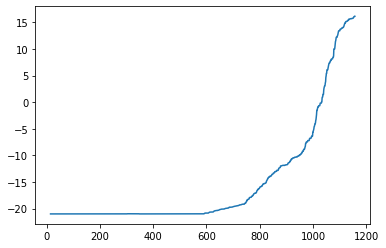

In [9]:
# ! pip install matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from ray.tune import Analysis
# change paths appropriately
analysis = Analysis("/home/qian/ray_results/PPO_PongNoFrameskip-v4_2020-03-11_18-30-45ra7xdyge")
df = analysis.dataframe()
df_trials = analysis.trial_dataframes['/home/qian/ray_results/PPO_PongNoFrameskip-v4_2020-03-11_18-30-45ra7xdyge']
df_trials['episode_reward_mean'].plot()

In [10]:
from ray.rllib.agents.dqn.dqn import DQNTrainer, DEFAULT_CONFIG

In [11]:
config = DEFAULT_CONFIG.copy()
config['num_gpus'] = 1
config['gamma']=0.99
config['lr'] = 0.0001
config['learning_starts'] = 10000
config['buffer_size'] = 50000
config['train_batch_size'] = 32
config['exploration_config']['epsilon_timesteps'] = 200000
config['exploration_config']['final_epsilon'] = 0.01
config['model']['grayscale'] = True
config['model']['zero_mean'] = False
config['model']['dim'] = 42

In [12]:
checkpoint_path = '/home/qian/ray_results/DQN_PongDeterministic-v4_2020-03-15_01-00-00jemj8dks/checkpoint_601/checkpoint-601'
trained_config = config.copy() 
agent = DQNTrainer(trained_config, 'PongDeterministic-v4')
agent.restore(checkpoint_path) 

/home/qian/anaconda3/envs/ray/lib/python3.7/site-packages/ray/rllib/utils/from_config.py:134: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  obj = yaml.load(type_)
2020-03-14 23:29:13,367	WARNING util.py:37 -- Install gputil for GPU system monitoring.
2020-03-14 23:29:13,483	WARNING trainable.py:210 -- Getting current IP.
2020-03-14 23:29:13,483	INFO trainable.py:416 -- Restored on 10.236.176.76 from checkpoint: /home/qian/ray_results/DQN_PongDeterministic-v4_2020-03-15_01-00-00jemj8dks/checkpoint_601/checkpoint-601
2020-03-14 23:29:13,484	INFO trainable.py:423 -- Current state after restoring: {'_iteration': 601, '_timesteps_total': 601000, '_time_total': 4291.144864320755, '_episodes_total': 404}


In [13]:
from gym import wrappers

env = agent.workers.local_worker().env
env = wrappers.Monitor(env, "./gym-results-dqn", force=True)
env.reset()

obs = env.observation_space.sample()
accum = 0
for _ in range(10000):
    frames = obs
    action = agent.compute_action(frames)
    obs, reward, done, info = env.step(action)
    accum += reward
    if done: break
print(accum)
env.close()

18.0


In [14]:
video = io.open('./gym-results-dqn/openaigym.video.%s.video000000.mp4' % env.file_infix, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
    <video width="360" height="auto" alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
.format(encoded.decode('ascii')))

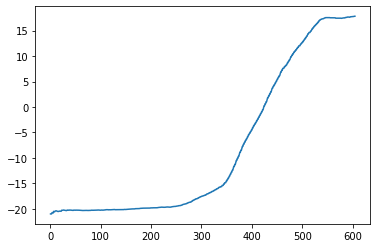

In [15]:
analysis = Analysis("/home/qian/ray_results/DQN_PongDeterministic-v4_2020-03-15_01-00-00jemj8dks")
df = analysis.dataframe()
df_trials = analysis.trial_dataframes['/home/qian/ray_results/DQN_PongDeterministic-v4_2020-03-15_01-00-00jemj8dks']
df_trials['episode_reward_mean'].plot()